Urban Data Science & Smart Cities <br>
URSP688Y Spring 2025<br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

# Demo 12 - Machine Learning

"All models are wrong, but some are useful." (George Box, 1976)

How would you prefer your model to be wrong so that it is most useful?

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

import demo12

%load_ext autoreload
%autoreload 2

# Data wrangling

In [2]:
# Load filings
df = pd.read_csv('md_eviction_filings.csv', low_memory=False)

## Construct tidy table for modeling units

In [3]:
df.head()

,EventDate,EventType,EventComment,County,TenantCity,TenantState,TenantZipCode,CaseType,CaseNumber,EvictedDate,SourceDate,Year,EvictionYear
0,2/10/23,Warrant of Restitution - Return of Service - E...,NaN,Baltimore,Baltimore,MD,21220,Failure to Pay Rent,74840,9/29/21,2/23/23,2023,2021.0
1,2/10/23,Warrant of Restitution - Return of Service - E...,NaN,Baltimore,Middle River,MD,21220,Failure to Pay Rent,74841,9/29/21,2/23/23,2023,2021.0
2,1/31/23,Warrant of Restitution - Return of Service - E...,NaN,Prince George's,Laurel,MD,20708,Failure to Pay Rent,15674,1/4/22,1/23/23,2023,2022.0
3,1/31/23,Warrant of Restitution - Return of Service - E...,NaN,Prince George's,Laurel,MD,20708,Breach of Lease,84154,1/5/22,1/23/23,2023,2022.0
4,1/31/23,Warrant of Restitution - Return of Service - E...,NaN,Prince George's,Temple Hills,MD,20748,Failure to Pay Rent,15902,1/6/22,1/23/23,2023,2022.0


In [4]:
# Make eviction indicator
df['evicted'] = df.EvictionYear.notnull().astype(int)

In [5]:
# Convert dates stored as strings to datetime objects 
df.EventDate = pd.to_datetime(df.EventDate, format='%m/%d/%y')
df.EvictedDate = pd.to_datetime(df.EvictedDate, format='%m/%d/%y')

In [6]:
# Retrieve first, min, or max values for each case
agg_funcs = {
    'EventDate': 'min',
    'County': 'first',
    'TenantCity': 'first',
    'TenantState': 'first',
    'TenantZipCode': 'first',
    'CaseType': 'first',
    'evicted': 'max',
}
df = df.groupby('CaseNumber').agg(agg_funcs)

In [7]:
df

,EventDate,County,TenantCity,TenantState,TenantZipCode,CaseType,evicted
CaseNumber,,,,,,,
0,2023-10-23,Prince George's,Lanham,MD,20706,Failure to Pay Rent,1
1,2023-10-23,Prince George's,Lanham,MD,20706,Failure to Pay Rent,1
2,2023-07-21,Baltimore City,Baltimore,MD,21224,Tenant Holding Over,1
3,2023-06-01,Baltimore City,Baltimore,MD,21205,Tenant Holding Over,1
4,2023-08-11,Baltimore City,Baltimore,MD,21217,Wrongful Detainer,0
...,...,...,...,...,...,...,...
84159,2023-07-25,Howard,Elkridge,MD,21075,Failure to Pay Rent,0
84160,2023-08-24,Howard,Columbia,MD,21045,Failure to Pay Rent,0
84161,2023-08-22,Howard,Ellicott City,MD,21043,Failure to Pay Rent,0


## Data Cleaning

In [8]:
# Remove records with an out-of-state zipcode
df[df.TenantZipCode == 7305]

,EventDate,County,TenantCity,TenantState,TenantZipCode,CaseType,evicted
CaseNumber,,,,,,,
34054,2023-05-05,Somerset,Jersey City,NJ,7305,Failure to Pay Rent,1


In [9]:
df = df[df.TenantZipCode != 7305]

In [10]:
# Recode single 'Breach Of Lease' CaseType value that's spelled wrong
df.CaseType.value_counts()

CaseType
Failure to Pay Rent    80170
Tenant Holding Over     2120
Wrongful Detainer       1228
Breach of Lease          644
Breach Of Lease            1
Name: count, dtype: int64

In [11]:
df = df.copy()

In [12]:
df.CaseType = df.CaseType.replace('Breach Of Lease', 'Breach of Lease')

In [13]:
df

,EventDate,County,TenantCity,TenantState,TenantZipCode,CaseType,evicted
CaseNumber,,,,,,,
0,2023-10-23,Prince George's,Lanham,MD,20706,Failure to Pay Rent,1
1,2023-10-23,Prince George's,Lanham,MD,20706,Failure to Pay Rent,1
2,2023-07-21,Baltimore City,Baltimore,MD,21224,Tenant Holding Over,1
3,2023-06-01,Baltimore City,Baltimore,MD,21205,Tenant Holding Over,1
4,2023-08-11,Baltimore City,Baltimore,MD,21217,Wrongful Detainer,0
...,...,...,...,...,...,...,...
84159,2023-07-25,Howard,Elkridge,MD,21075,Failure to Pay Rent,0
84160,2023-08-24,Howard,Columbia,MD,21045,Failure to Pay Rent,0
84161,2023-08-22,Howard,Ellicott City,MD,21043,Failure to Pay Rent,0


## Construct new features

In [14]:
# Calculate a feature for month of first filing
df['event_month'] = df.EventDate.dt.month

In [15]:
# Calculate a feature for the number of days before the end of the month on which an event was first filed
df['event_days_before_end_of_month'] = df.EventDate.dt.daysinmonth - df['EventDate'].dt.day

In [16]:
# Case case type dummies
df = pd.concat([df, pd.get_dummies(df.CaseType, prefix='case_type').astype(int)], axis=1)

# Make county dummies
df = pd.concat([df, pd.get_dummies(df.County, prefix='county').astype(int)], axis=1)

# Make zip dummies
df = pd.concat([df, pd.get_dummies(df.TenantZipCode, prefix='zip').astype(int)], axis=1)

In [17]:
# df

# Model Specification

## Define Features and Outcome Variable

Want enough features with well-theorized relationships to the outcome to achieve a strong and generalizable model fit.

- Want to avoid underfitting
- Want to avoid overfitting

<img alt="Underfitting and Overfitting Example" src='https://miro.medium.com/v2/resize:fit:720/format:webp/0*vayIXMjSp3ezj4G6.png'>

[Source: https://medium.com/@satyam3196/everything-you-need-to-know-about-model-fitting-in-machine-learning-4f93dccc6bf1](https://medium.com/@satyam3196/everything-you-need-to-know-about-model-fitting-in-machine-learning-4f93dccc6bf1)

In [49]:
# Split dataset in features and target variable
features = [ 
    # Date
    'event_month',
    'event_days_before_end_of_month',
    
    # Case type
    # 'case_type_Failure to Pay Rent',
    'case_type_Breach of Lease',
    'case_type_Tenant Holding Over',
    'case_type_Wrongful Detainer',
    
    # County
    'county_Allegany',
    'county_Anne Arundel',
    'county_Baltimore',
    # 'county_Baltimore City',
    'county_Calvert',
    'county_Caroline',
    'county_Carroll',
    'county_Cecil',
    'county_Charles',
    'county_Dorchester',
    'county_Frederick',
    'county_Garrett',
    'county_Harford',
    'county_Howard',
    'county_Kent',
    'county_Montgomery',
    "county_Prince George's",
    "county_Queen Anne's",
    "county_Saint Mary's",
    'county_Somerset',
    'county_Talbot',
    'county_Washington',
    'county_Wicomico',
    'county_Worcester',
    
    # Zip
    # 'zip_10022',
    'zip_11214',
    'zip_19350',
    'zip_19711',
    'zip_19802',
    'zip_19973',
    'zip_20002',
    'zip_20032',
    'zip_20062',
    'zip_20132',
    'zip_20146',
    'zip_20160',
    'zip_20171',
    'zip_20176',
    'zip_20201',
    'zip_20207',
    'zip_20212',
    'zip_20239',
    'zip_20474',
    'zip_20555',
    'zip_20601',
    'zip_20602',
    'zip_20603',
    'zip_20607',
    'zip_20608',
    'zip_20609',
    'zip_20611',
    'zip_20613',
    'zip_20616',
    'zip_20617',
    'zip_20618',
    'zip_20619',
    'zip_20620',
    'zip_20621',
    'zip_20622',
    'zip_20623',
    'zip_20634',
    'zip_20636',
    'zip_20637',
    'zip_20639',
    'zip_20640',
    'zip_20646',
    'zip_20650',
    'zip_20653',
    'zip_20656',
    'zip_20657',
    'zip_20658',
    'zip_20659',
    'zip_20662',
    'zip_20664',
    'zip_20667',
    'zip_20670',
    'zip_20675',
    'zip_20676',
    'zip_20677',
    'zip_20678',
    'zip_20680',
    'zip_20684',
    'zip_20685',
    'zip_20688',
    'zip_20689',
    'zip_20695',
    'zip_20697',
    'zip_20701',
    'zip_20705',
    'zip_20706',
    'zip_20707',
    'zip_20708',
    'zip_20710',
    'zip_20711',
    'zip_20712',
    'zip_20714',
    'zip_20715',
    'zip_20716',
    'zip_20720',
    'zip_20721',
    'zip_20722',
    'zip_20723',
    'zip_20724',
    'zip_20725',
    'zip_20732',
    'zip_20733',
    'zip_20735',
    'zip_20736',
    'zip_20737',
    'zip_20740',
    'zip_20743',
    'zip_20744',
    'zip_20745',
    'zip_20746',
    'zip_20747',
    'zip_20748',
    'zip_20749',
    'zip_20751',
    'zip_20754',
    'zip_20759',
    'zip_20763',
    'zip_20764',
    'zip_20769',
    'zip_20770',
    'zip_20772',
    'zip_20773',
    'zip_20774',
    'zip_20776',
    'zip_20777',
    'zip_20781',
    'zip_20782',
    'zip_20783',
    'zip_20784',
    'zip_20785',
    'zip_20786',
    'zip_20794',
    'zip_20805',
    'zip_20810',
    'zip_20814',
    'zip_20815',
    'zip_20816',
    'zip_20817',
    'zip_20824',
    'zip_20832',
    'zip_20833',
    'zip_20837',
    'zip_20841',
    'zip_20847',
    'zip_20850',
    'zip_20851',
    'zip_20852',
    'zip_20853',
    'zip_20854',
    'zip_20855',
    'zip_20857',
    'zip_20861',
    'zip_20862',
    'zip_20866',
    'zip_20868',
    'zip_20871',
    'zip_20872',
    'zip_20874',
    'zip_20875',
    'zip_20876',
    'zip_20877',
    'zip_20878',
    'zip_20879',
    'zip_20882',
    'zip_20886',
    'zip_20895',
    'zip_20901',
    'zip_20902',
    'zip_20903',
    'zip_20904',
    'zip_20905',
    'zip_20906',
    'zip_20908',
    'zip_20910',
    'zip_20912',
    'zip_20914',
    'zip_20985',
    'zip_21001',
    'zip_21009',
    'zip_21012',
    'zip_21013',
    'zip_21014',
    'zip_21015',
    'zip_21017',
    'zip_21028',
    'zip_21029',
    'zip_21030',
    'zip_21032',
    'zip_21034',
    'zip_21035',
    'zip_21036',
    'zip_21037',
    'zip_21040',
    'zip_21042',
    'zip_21043',
    'zip_21044',
    'zip_21045',
    'zip_21046',
    'zip_21047',
    'zip_21048',
    'zip_21050',
    'zip_21051',
    'zip_21054',
    'zip_21057',
    'zip_21060',
    'zip_21061',
    'zip_21071',
    'zip_21074',
    'zip_21075',
    'zip_21076',
    'zip_21077',
    'zip_21078',
    'zip_21084',
    'zip_21085',
    'zip_21087',
    'zip_21090',
    'zip_21093',
    'zip_21102',
    'zip_21108',
    'zip_21111',
    'zip_21113',
    'zip_21114',
    'zip_21117',
    'zip_21121',
    'zip_21122',
    'zip_21123',
    'zip_21128',
    'zip_21130',
    'zip_21131',
    'zip_21132',
    'zip_21133',
    'zip_21136',
    'zip_21144',
    'zip_21146',
    'zip_21152',
    'zip_21154',
    'zip_21157',
    'zip_21158',
    'zip_21162',
    'zip_21163',
    'zip_21178',
    'zip_21201',
    'zip_21202',
    'zip_21203',
    'zip_21204',
    'zip_21205',
    'zip_21206',
    'zip_21207',
    'zip_21208',
    'zip_21209',
    'zip_21210',
    'zip_21211',
    'zip_21212',
    'zip_21213',
    'zip_21214',
    'zip_21215',
    'zip_21216',
    'zip_21217',
    'zip_21218',
    'zip_21219',
    'zip_21220',
    'zip_21221',
    'zip_21222',
    'zip_21223',
    'zip_21224',
    'zip_21225',
    'zip_21226',
    'zip_21227',
    'zip_21228',
    'zip_21229',
    'zip_21230',
    'zip_21231',
    'zip_21233',
    'zip_21234',
    'zip_21236',
    'zip_21237',
    'zip_21238',
    'zip_21239',
    'zip_21244',
    'zip_21267',
    'zip_21281',
    'zip_21284',
    'zip_21285',
    'zip_21286',
    'zip_21288',
    'zip_21401',
    'zip_21403',
    'zip_21404',
    'zip_21409',
    'zip_21502',
    'zip_21503',
    'zip_21520',
    'zip_21521',
    'zip_21529',
    'zip_21532',
    'zip_21536',
    'zip_21539',
    'zip_21541',
    'zip_21550',
    'zip_21555',
    'zip_21557',
    'zip_21562',
    'zip_21601',
    'zip_21610',
    'zip_21612',
    'zip_21613',
    'zip_21617',
    'zip_21619',
    'zip_21620',
    'zip_21629',
    'zip_21630',
    'zip_21631',
    'zip_21632',
    'zip_21635',
    'zip_21636',
    'zip_21638',
    'zip_21639',
    'zip_21640',
    'zip_21641',
    'zip_21643',
    'zip_21648',
    'zip_21649',
    'zip_21651',
    'zip_21655',
    'zip_21657',
    'zip_21658',
    'zip_21659',
    'zip_21660',
    'zip_21661',
    'zip_21662',
    'zip_21663',
    'zip_21666',
    'zip_21673',
    'zip_21701',
    'zip_21702',
    'zip_21703',
    'zip_21704',
    'zip_21710',
    'zip_21713',
    'zip_21714',
    'zip_21716',
    'zip_21718',
    'zip_21719',
    'zip_21722',
    'zip_21727',
    'zip_21733',
    'zip_21734',
    'zip_21737',
    'zip_21740',
    'zip_21741',
    'zip_21742',
    'zip_21746',
    'zip_21750',
    'zip_21754',
    'zip_21755',
    'zip_21758',
    'zip_21769',
    'zip_21770',
    'zip_21771',
    'zip_21774',
    'zip_21776',
    'zip_21777',
    'zip_21782',
    'zip_21783',
    'zip_21784',
    'zip_21787',
    'zip_21788',
    'zip_21791',
    'zip_21793',
    'zip_21794',
    'zip_21795',
    'zip_21797',
    'zip_21801',
    'zip_21802',
    'zip_21804',
    'zip_21811',
    'zip_21813',
    'zip_21817',
    'zip_21821',
    'zip_21822',
    'zip_21826',
    'zip_21829',
    'zip_21830',
    'zip_21835',
    'zip_21837',
    'zip_21838',
    'zip_21842',
    'zip_21849',
    'zip_21850',
    'zip_21851',
    'zip_21853',
    'zip_21856',
    'zip_21861',
    'zip_21863',
    'zip_21865',
    'zip_21867',
    'zip_21871',
    'zip_21872',
    'zip_21874',
    'zip_21875',
    'zip_21901',
    'zip_21903',
    'zip_21904',
    'zip_21911',
    'zip_21912',
    'zip_21913',
    'zip_21914',
    'zip_21915',
    'zip_21917',
    'zip_21918',
    'zip_21919',
    'zip_21920',
    'zip_21921',
    'zip_21922',
    'zip_21978',
    'zip_22769',
    'zip_25401',
    'zip_27048',
    'zip_33458',
    'zip_55403',
    'zip_75001',
]

X = df[features] # Features
y = df.evicted # Outcome variable

## Split Data for Training and Testing

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [51]:
len(X_train)

63122

In [52]:
len(X_test)

21041

# Logistic Regression

## Train

In [53]:
# Initialize the model object
logreg = LogisticRegression(random_state=1, max_iter=1000)

# Estimate/fit the model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1)

## Test

In [54]:
# By default, the model predicts an outcome of level 1 (eviction)
# if the probability is greater than 0.5
y_pred = logreg.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0], shape=(21041,))

In [55]:
# Alternatively, we could generalize prediction with a custom probability threshold  
def predict_with_threshold(model, X_test, threshold=0.5):
    y_pred_proba = model.predict_proba(X_test)[:,1]
    return (y_pred_proba > threshold).astype(int)

y_pred = predict_with_threshold(logreg, X_test, threshold=0.9)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(21041,))

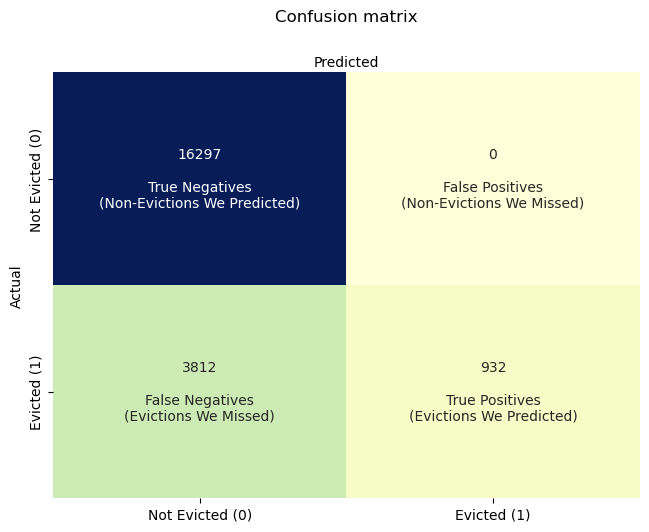

In [56]:
demo12.confusion_matrix(y_test, y_pred)

# Assessing Model "Fit"

This is always going to be a balance between more and less sensitivity to the outcome you want to predict.

Do you want more or fewer false alarms? How much do you want to "cry wolf"?

### Accuracy
Proportion of classifications that are correct.

$$
Accuracy = \frac{Correct Classifications}{Total Classifications} = \frac{True Positives + True Negatives}{True Positives + True Negatives + False Positives + False Negatives}
$$

### Precision/Specificity
Proportion of positive predictions that are correct.

You want precision to be high if it's bad to have false positives (e.g., if unnecessary identification and treatment has many downsides).

$$
Precision = \frac{True Positives}{True Positives + False Positives}
$$

### Recall/Sensitivity/True Positive Rate
Proportion of actual positives that are predicted correctly.

You want recall to be high if it's bad to have false negatives (e.g., if you would rather identify and treat even if it's not strictly necessary).

$$
Recall = \frac{True Positives}{True Positives + False Negatives}
$$

In [57]:
demo12.precision_recall_table(y_test, y_pred)

,precision,recall,f1-score,support
not evicted,0.810433,1.000000,0.895292,16297.00000
evicted,1.000000,0.196459,0.328400,4744.00000
accuracy,0.818830,0.818830,0.818830,0.81883
macro avg,0.905217,0.598229,0.611846,21041.00000
weighted avg,0.853174,0.818830,0.767478,21041.00000


- A larger proportion of non-eviction predictions correct (higher precision).
- We are predicting about the same proportion of actual eviction and non-eviction cases (~70% recall).
- Overall, the model is correctly classifying 70% of cases.

### Receiver Operating Characteristic (ROC) Curve

Built by iterating classification thresholds between 0 and 1, then plotting sensitivity against specificity for the resulting outcomes.

Shows the performance of the model at all possible classification thresholds.

The closer the curve is to a right angle, the better the model.

Area Under the Curve (AUC) summarizes performance; better models approach 1.0.

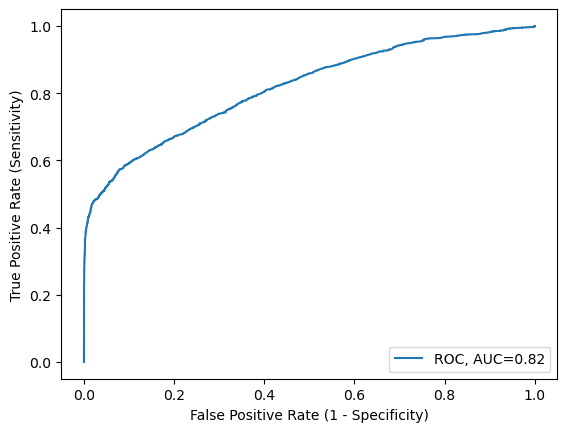

In [58]:
demo12.roc_plot(logreg, y_test, X_test)

# Random Forest

A collection of (many, many) decision trees

<img alt="Random forest decision tree example" src='https://miro.medium.com/v2/resize:fit:1184/format:webp/1*i0o8mjFfCn-uD79-F1Cqkw.png'>

[Source: https://williamkoehrsen.medium.com/random-forest-simple-explanation-377895a60d2d](https://williamkoehrsen.medium.com/random-forest-simple-explanation-377895a60d2d)

## Train

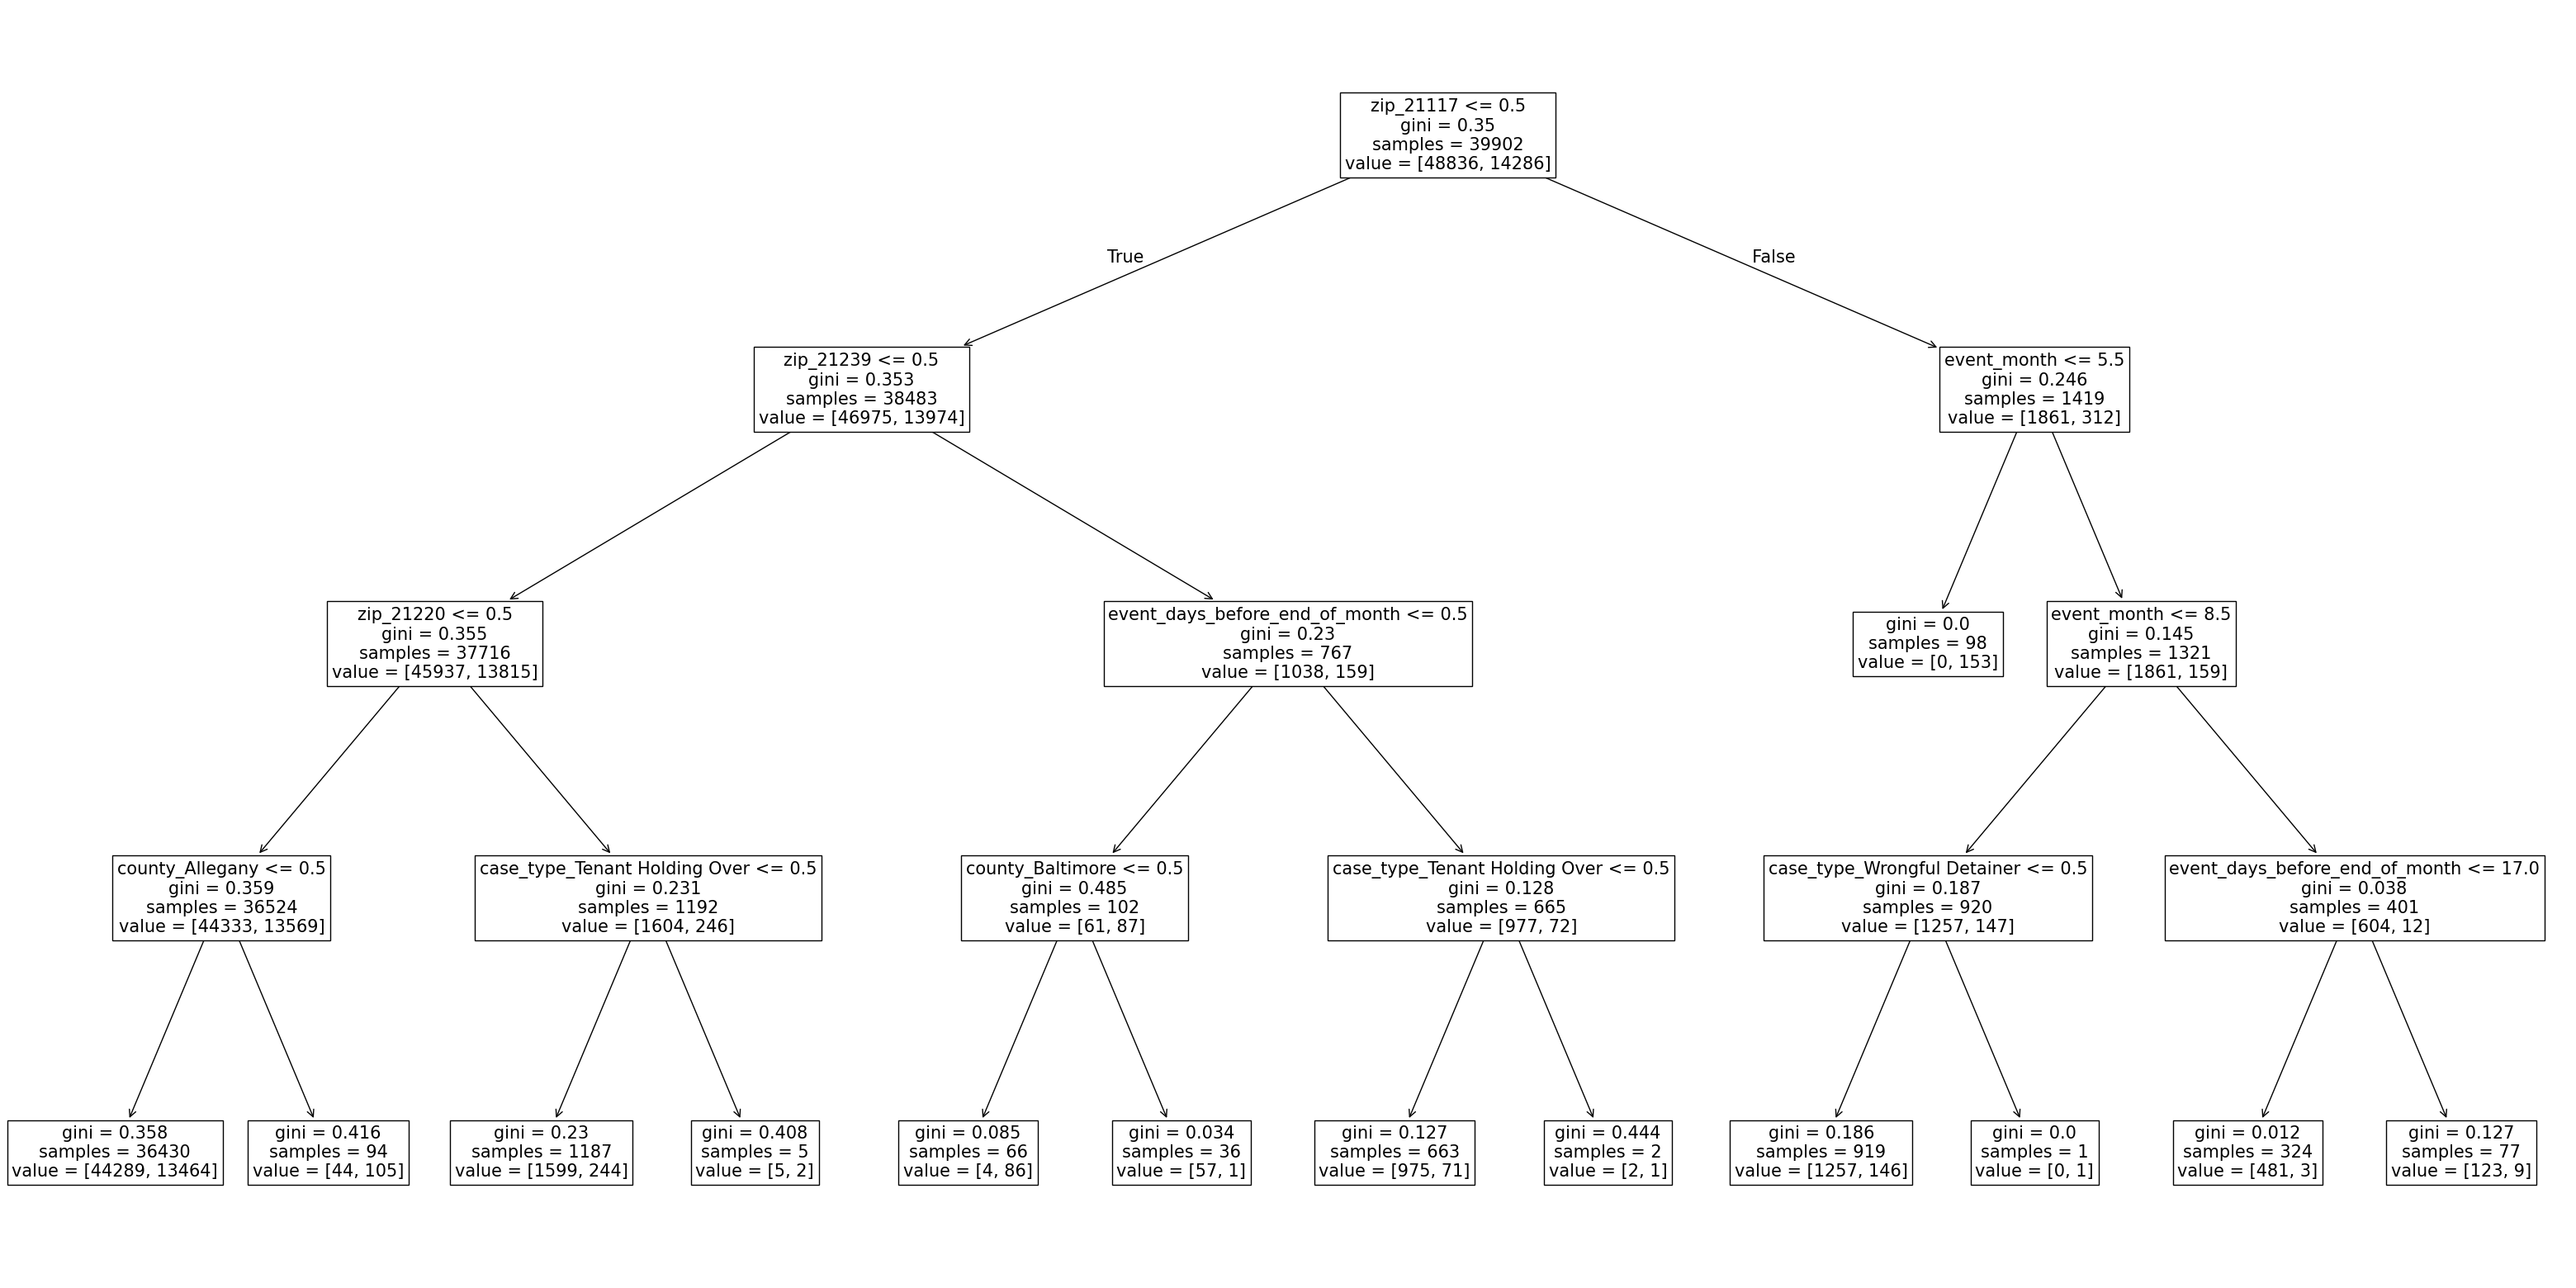

In [69]:
# Initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1, n_jobs=-1, max_depth=4) 

# Fit the model based on training data
rf.fit(X_train, y_train)

# Visualize the first estimator/tree
e = rf.estimators_[2]

fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)

In [60]:
## Now let's allow the depth of decision trees to be unlimited
## (Nodes are expanded until each leaf contains one observation)

# Initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 100, random_state = 1, max_depth=None)

# Fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

## Test

In [61]:
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(21041,))

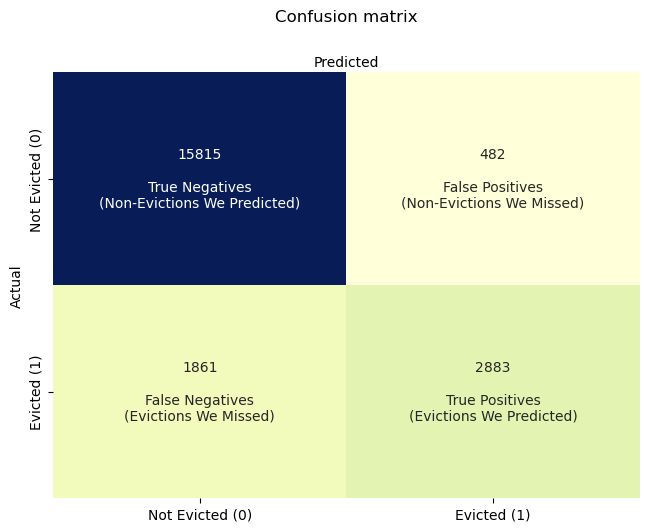

In [62]:
demo12.confusion_matrix(y_test, y_pred)

In [63]:
demo12.precision_recall_table(y_test, y_pred)

,precision,recall,f1-score,support
not evicted,0.894716,0.970424,0.931033,16297.000000
evicted,0.856761,0.607715,0.711062,4744.000000
accuracy,0.888646,0.888646,0.888646,0.888646
macro avg,0.875738,0.789070,0.821048,21041.000000
weighted avg,0.886158,0.888646,0.881438,21041.000000


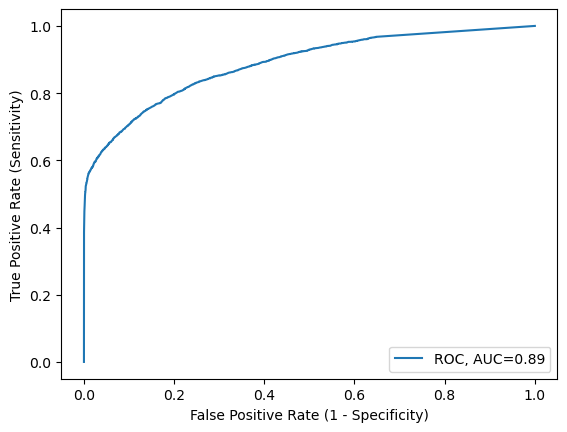

In [64]:
demo12.roc_plot(rf, y_test, X_test)